In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

# ---------------------------
# 1) Load built-in sklearn dataset
# ---------------------------
data = load_diabetes(as_frame=True)
df = data.frame.copy()
print(df)



          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  target  
0   -0.002592  0.019907 -0.0176

In [35]:
# Business framing:
# We'll treat the target as a KPI (e.g., "daily claims cost index" or "daily revenue index")
# To create a time-like order, sort by one feature as a proxy for "time progression".
# (You can also just use df.sample(frac=1, random_state=42) to simulate random days.)
df = df.sort_values("age").reset_index(drop=True)

# Create a "day" index
df["day"] = np.arange(1, len(df) + 1)

# Create a KPI signal from the target, then add noise to simulate real-world volatility
rng = np.random.default_rng(42)
base_kpi = df["target"].to_numpy()

# Add realistic business noise + a small weekly seasonality pattern
noise = rng.normal(0, base_kpi.std() * 0.15, size=len(base_kpi))
weekly = 0.10 * base_kpi.std() * np.sin(2 * np.pi * df["day"].to_numpy() / 7)

kpi = base_kpi + noise + weekly
df["kpi_raw"] = kpi

print(df)

          age       sex       bmi        bp        s1        s2        s3  \
0   -0.107226 -0.044642 -0.077342 -0.026328 -0.089630 -0.096198  0.026550   
1   -0.107226 -0.044642 -0.034229 -0.067642 -0.063487 -0.070520  0.008142   
2   -0.107226 -0.044642 -0.011595 -0.040099  0.049341  0.064447 -0.013948   
3   -0.103593  0.050680 -0.023451 -0.022885 -0.086878 -0.067701 -0.017629   
4   -0.103593  0.050680 -0.046085 -0.026328 -0.024960 -0.024800  0.030232   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.092564 -0.044642  0.036907  0.021872 -0.024960 -0.016658  0.000779   
438  0.096197 -0.044642  0.040140 -0.057313  0.045213  0.060690 -0.021311   
439  0.096197 -0.044642  0.051996  0.079265  0.054845  0.036577 -0.076536   
440  0.110727  0.050680  0.006728  0.028758 -0.027712 -0.007264 -0.047082   
441  0.110727  0.050680 -0.033151 -0.022885 -0.004321  0.020293 -0.061809   

           s4        s5        s6  target  day     kpi_raw  
0   -0.076395 

In [36]:
# ---------------------------
# 2) Rolling Mean Smoothing
# ---------------------------
# Window choice depends on business rhythm:
# 7 = weekly smoothing, 14 = two-week smoothing, etc.
window = 7
df["kpi_rollmean"] = df["kpi_raw"].rolling(window=window, center=True).mean()

print(df)

          age       sex       bmi        bp        s1        s2        s3  \
0   -0.107226 -0.044642 -0.077342 -0.026328 -0.089630 -0.096198  0.026550   
1   -0.107226 -0.044642 -0.034229 -0.067642 -0.063487 -0.070520  0.008142   
2   -0.107226 -0.044642 -0.011595 -0.040099  0.049341  0.064447 -0.013948   
3   -0.103593  0.050680 -0.023451 -0.022885 -0.086878 -0.067701 -0.017629   
4   -0.103593  0.050680 -0.046085 -0.026328 -0.024960 -0.024800  0.030232   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.092564 -0.044642  0.036907  0.021872 -0.024960 -0.016658  0.000779   
438  0.096197 -0.044642  0.040140 -0.057313  0.045213  0.060690 -0.021311   
439  0.096197 -0.044642  0.051996  0.079265  0.054845  0.036577 -0.076536   
440  0.110727  0.050680  0.006728  0.028758 -0.027712 -0.007264 -0.047082   
441  0.110727  0.050680 -0.033151 -0.022885 -0.004321  0.020293 -0.061809   

           s4        s5        s6  target  day     kpi_raw  kpi_rollmean  


In [37]:
# ---------------------------
# 3) Kernel Smoothing (Nadaraya–Watson with Gaussian kernel)
# ---------------------------
def gaussian_kernel_smooth(x, y, bandwidth):
    """
    x: 1D array of positions (days)
    y: 1D array of values (KPI)
    bandwidth: smoothing strength (larger = smoother)
    returns y_smooth
    """
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Pairwise squared distances
    d2 = (x - x.T) ** 2

    # Gaussian weights
    W = np.exp(-d2 / (2 * bandwidth**2))

    # Weighted average for each point
    y_smooth = (W @ y) / (W.sum(axis=1, keepdims=True))
    return y_smooth.ravel()

x = df["day"].to_numpy()
y = df["kpi_raw"].to_numpy()

# Bandwidth: think of it like "how many days influence each point"
bandwidth = 10
df["kpi_kernel"] = gaussian_kernel_smooth(x, y, bandwidth=bandwidth)



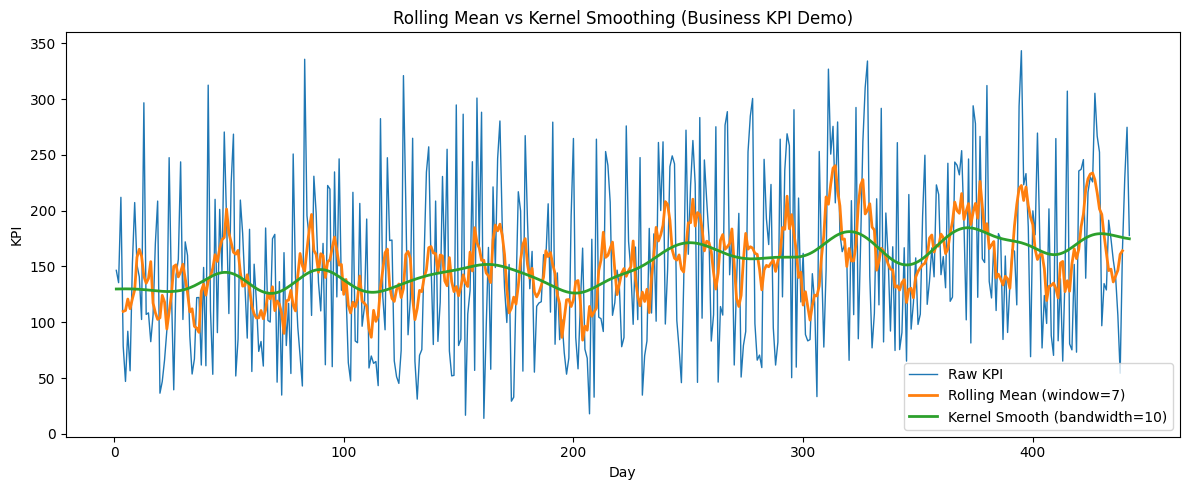

In [38]:
# ---------------------------
# 4) Plot: Raw vs Smoothed
# ---------------------------
plt.figure(figsize=(12, 5))
plt.plot(df["day"], df["kpi_raw"], label="Raw KPI", linewidth=1)
plt.plot(df["day"], df["kpi_rollmean"], label=f"Rolling Mean (window={window})", linewidth=2)
plt.plot(df["day"], df["kpi_kernel"], label=f"Kernel Smooth (bandwidth={bandwidth})", linewidth=2)
plt.title("Rolling Mean vs Kernel Smoothing (Business KPI Demo)")
plt.xlabel("Day")
plt.ylabel("KPI")
plt.legend()
plt.tight_layout()
plt.show()



In [39]:
# ---------------------------
# 5) Optional: Compare volatility reduction
# ---------------------------
print("Std Dev (Raw):       ", df["kpi_raw"].std())
print("Std Dev (Rolling):   ", df["kpi_rollmean"].dropna().std())
print("Std Dev (Kernel):    ", df["kpi_kernel"].std())

Std Dev (Raw):        76.41739830002696
Std Dev (Rolling):    31.2627415248443
Std Dev (Kernel):     17.554719766743638
